# Задача 5

Импорт модулей

In [612]:
import numpy as np
from numpy import pi, sin, cos, sqrt
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.rcParams.update({'font.size': 20})

from scipy.misc import derivative
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

try:
  from google.colab import drive
  drive.mount('/content/drive')
  IN_COLAB = True
except:
  IN_COLAB = False

Чтение файлов

In [613]:
if IN_COLAB:
  NRLMSIS_day = np.loadtxt('/content/drive/MyDrive/exam_rrv/NRLMSIS_day.txt', skiprows=1)
  NRLMSIS_night = np.loadtxt('/content/drive/MyDrive/exam_rrv/NRLMSIS_night.txt', skiprows=1)
  IRI_day = np.loadtxt('/content/drive/MyDrive/exam_rrv/IRI2016_day.txt', skiprows=35)
  IRI_night = np.loadtxt('/content/drive/MyDrive/exam_rrv/IRI2016_night.txt', skiprows=35)
else:
  NRLMSIS_day = np.loadtxt('NRLMSIS_day.txt', skiprows=1)
  NRLMSIS_night = np.loadtxt('NRLMSIS_night.txt', skiprows=1)
  IRI_day = np.loadtxt('IRI2016_day.txt', skiprows=35)
  IRI_night = np.loadtxt('IRI2016_night.txt', skiprows=35)

Создание массивов

In [614]:
N_e_day = np.array([item[1] for item in IRI_day], dtype=np.longdouble)
N_e_night = np.array([item[1] for item in IRI_night], dtype=np.longdouble)
z = np.array([item[0] for item in IRI_day], dtype=int) * 1000

Чистка данных

In [615]:
mask_day = N_e_day != -1
mask_night = N_e_night != -1

N_e_day = N_e_day[mask_day]
N_e_night = N_e_night[mask_night]

z_day = z[mask_day]
z_night = z[mask_night]

In [616]:
if 0:
    z, N_e = z_night, N_e_night
else:
    z, N_e = z_day, N_e_day

Блок с константами

In [617]:
date = dt.datetime(int(NRLMSIS_day[0][0]), int(NRLMSIS_day[0][1]), int(NRLMSIS_day[0][2]), int(NRLMSIS_day[0][4]))

e_charge = 4.8e-10
mass_e = 9.1094e-28
omega = 2 * pi * (5 * 1e6)

Блок с формулами для расчетов

In [618]:
omega_plasm = sqrt((4 * pi * (e_charge ** 2) * N_e / mass_e))
n_quad = 1 - ((omega_plasm**2)/(omega ** 2))
n = sqrt(n_quad + 0j)
n_for_graph = sqrt(n_quad)


In [619]:
interpol_n = interp1d(z, n, kind = 'cubic')

In [620]:
len(N_e)

935

На 3 ГГц мнимая часть n идеально описывает максимум электронного распределения, но разнится с ней по краям

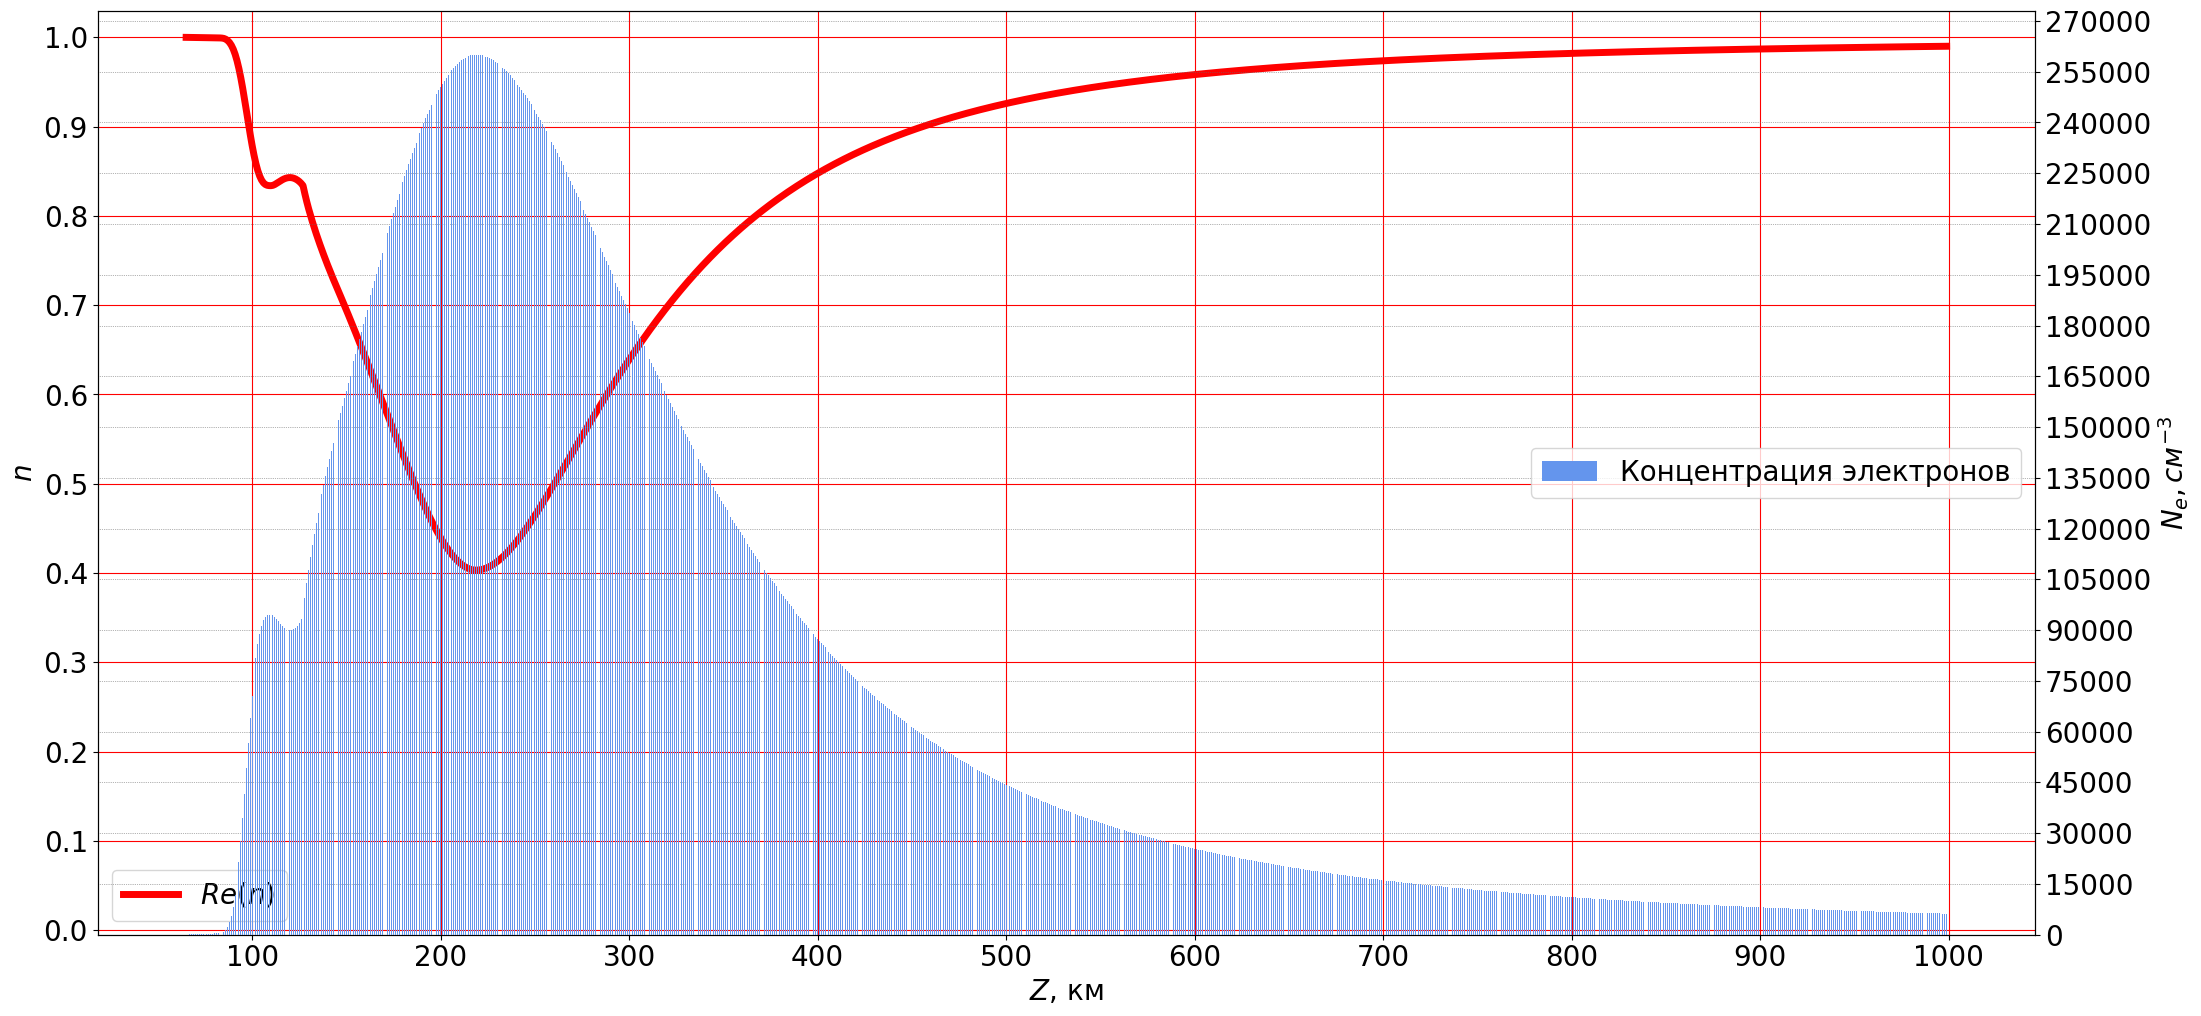

In [621]:
fig, ax = plt.subplots(figsize=(25, 12))
ax.plot(z/1000, n.real, label='$Re(n)$', color='r', linewidth=5, zorder = 10)
if np.sum(n.imag) != 0: 
    ax.plot(z/1000, n.imag, label='$Im(n)$', color='g', linewidth=5, zorder = 10)
ax.set_ylabel('$n$')
ax.set_xlabel('$Z$, км')
ax.set_ylim(-0.005)
ax.grid(True, color='r')
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.legend()
    
ax2 = ax.twinx()
ax2.bar(z/1000, N_e, zorder = 5, color='cornflowerblue', label = 'Концентрация электронов', width = 0.45)
ax2.set_ylabel('$N_e, {см}^{-3}$')
ax2.yaxis.set_major_locator(ticker.MultipleLocator(15000))
ax2.grid(which='major', color = 'dimgrey', linestyle = ':', linewidth = 0.5)
plt.legend(loc = 'center right')

Интегрирование

In [622]:
def dp_zdt(z, n):
    try:
        # считаем прозводную
        d = 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1)
    except:
        # если не получилось, значит нет данных, потому что в слое мало электронов
        # следовательно, n = 1 и производная равна 0
        d = 0
    return d

# система ДУ
def ode(t, p, n, p_x, p_y): 
    # распаковка
    x, y, z, p_z = p
    # если траектория ушла под землю, зануляем координаты
    if z < 0: p_x, p_y, p_z = 0, 0, 0
    return [p_x, p_y, p_z, dp_zdt(z, n)]

def solve(n, z0, teta_0, phi_0, t):
    p_x0 = sin(teta_0) * cos(phi_0)
    p_y0 = sin(teta_0) * sin(phi_0)
    p_z0 = cos(teta_0)
    
    #print(p_x0, p_y0, p_z0)
    p0 = [0, 0, z0, p_z0]
    sol = solve_ivp(ode, [t[0], t[-1]], p0, args=(n, p_x0, p_y0), dense_output=True)
    return sol.sol(t)

C:\Users\astro\AppData\Local\Temp\ipykernel_16516\3265896529.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d = 0.5 * derivative(lambda z: n(z)**2, z, dx=1, n=1)
C:\Users\astro\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_ivp\base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


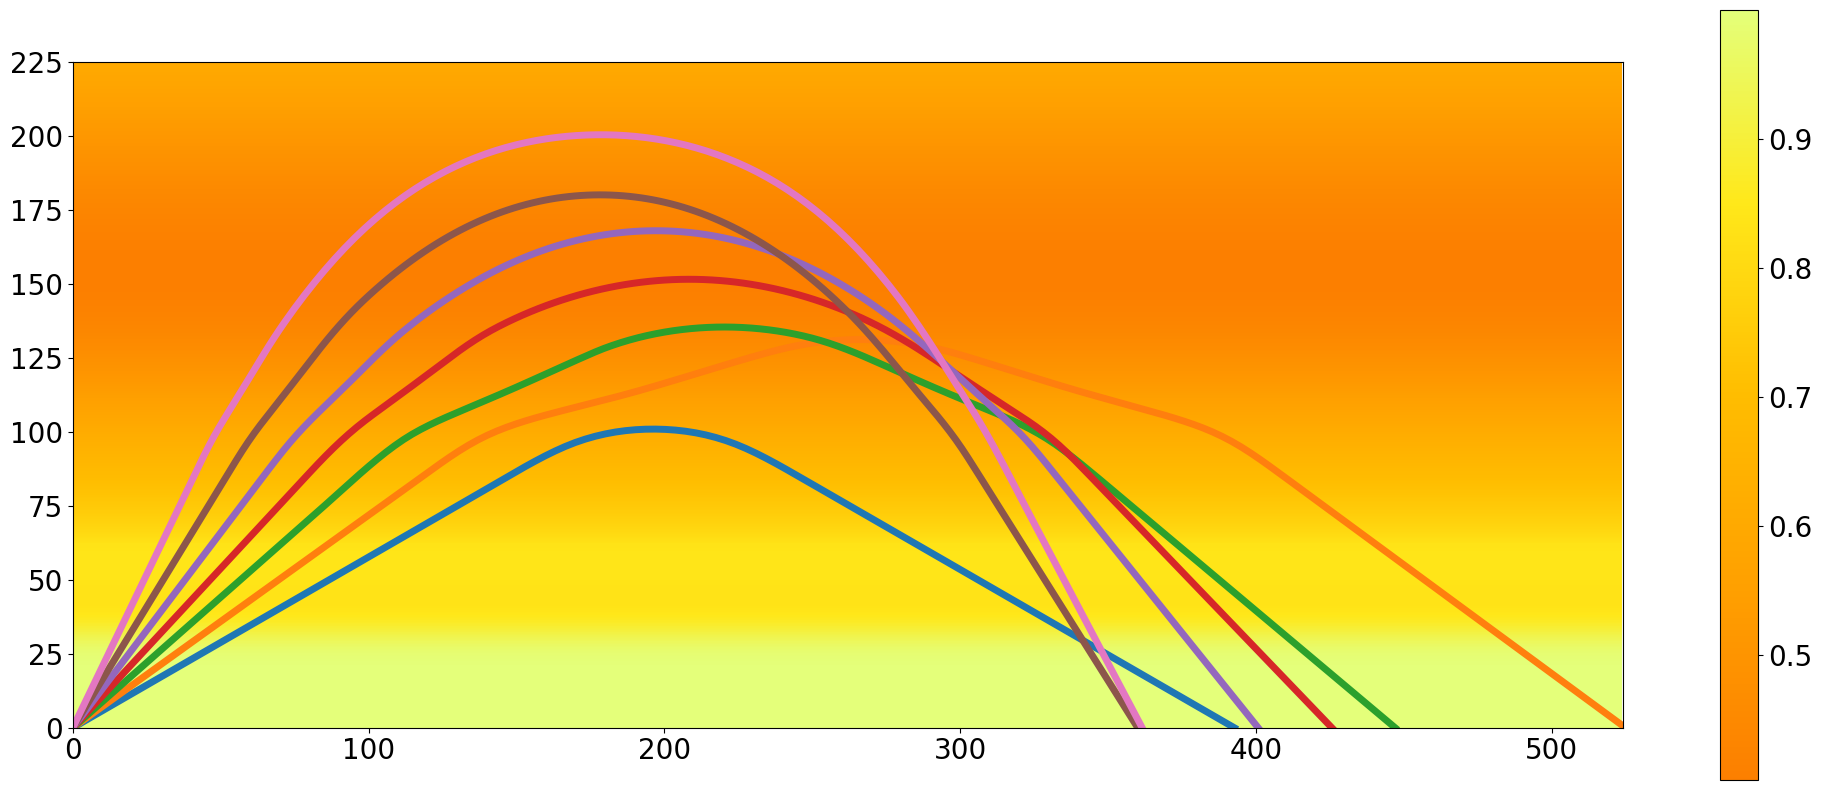

In [623]:
x_max_on_line = []
z_max_on_line = []

fig = plt.figure(figsize=(25, 10))

for theta in np.linspace(pi/3, pi/7, 7):
    t = np.linspace(0, 1000e3, 2**8) # читай как оптический путь
    x, y, z, p_z = solve(interpol_n, 0, theta, 0, t)
    x_max_on_line.append(int(x.max()/1e3))
    z_max_on_line.append(int(z.max()/1e3))
    plt.plot(x/1e3, z/1e3, linewidth=5)
    
plt.imshow(np.tile(n_for_graph.reshape(-1, 1)[0:np.array(z_max_on_line).max() + 25], np.array(x_max_on_line).max()), origin='lower', cmap=plt.cm.Wistia.reversed())
plt.ylim(0, np.array(z_max_on_line).max() + 25)
plt.xlim(0, np.array(x_max_on_line).max())
plt.colorbar()